# ĐỒ ÁN CUỐI KÌ MÔN NHẬP MÔN KHOA HỌC DỮ LIỆU


### Giảng viên hướng dần: Thầy Trần Trung Kiên
### Thành viên thực hiện
- 1712302 Bùi Lý Chung 
- 1712575 -Hoàng Xuân Long

In [346]:
import requests
from bs4 import BeautifulSoup
import json
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd
import datetime as dt
import re
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn import set_config
set_config(display='diagram')

---
## 1. Thu thập dữ liệu từ web Zillow bằng cách parse HTML 
File này gồm có các cột:
- Address: Địa chỉ nhà.
- Price: Gía nhà (là giá của nhà đã bán).
- Bedrooms: số phòng ngủ.
- Bathrooms: số phòng tắm.
- Living Area: Diện tích căn nhà (sqft).
- Heating : Hệ thống sưởi.
- Basement : Tầng hầm(Yes/No).
- Yearbuild: Năm xây dựng.
- Fireplace: Lò sưởi(Yes/No).
- Garage: Nhà xe.


In [103]:
Total_pages=20
req_headers = {
    'accept':'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
    'accept-encoding':'gzip, deflate, sdch, br',
    'accept-language':'en-GB,en;q=0.8,en-US;q=0.6,ml;q=0.4',
    'cache-control':'max-age=0',
    'upgrade-insecure-requests':'1',
    'user-agent':'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.87 Safari/537.36'}
courses =pd.DataFrame()
Address_ =[]
Price_=[]
Bedrooms_=[]
Bathrooms_ =[]
LivingArea_ = []
Heating_ =[]
Basement_ =[]
Yearbuild_ =[]
Fireplace_ =[]
Garage_ =[]
with requests.Session() as s:
    page =1
    url = 'https://www.zillow.com/manchester-ct/sold/?searchQueryState=%7B"pagination"%3A%7B%7D%2C"usersSearchTerm"%3A"Manchester%2C%20CT"%2C"mapBounds"%3A%7B"west"%3A-72.62056917797851%2C"east"%3A-72.42659182202148%2C"south"%3A41.72559685174378%2C"north"%3A41.82852106786825%7D%2C"regionSelection"%3A%5B%7B"regionId"%3A398963%2C"regionType"%3A6%7D%5D%2C"isMapVisible"%3Atrue%2C"filterState"%3A%7B"fsba"%3A%7B"value"%3Afalse%7D%2C"fsbo"%3A%7B"value"%3Afalse%7D%2C"nc"%3A%7B"value"%3Afalse%7D%2C"fore"%3A%7B"value"%3Afalse%7D%2C"cmsn"%3A%7B"value"%3Afalse%7D%2C"auc"%3A%7B"value"%3Afalse%7D%2C"pmf"%3A%7B"value"%3Afalse%7D%2C"pf"%3A%7B"value"%3Afalse%7D%2C"rs"%3A%7B"value"%3Atrue%7D%2C"ah"%3A%7B"value"%3Atrue%7D%7D%2C"isListVisible"%3Atrue%2C"mapZoom"%3A13%7D'
    while(page < Total_pages):
        #time.sleep(1)
        r = s.get(url, headers=req_headers)
        soup = BeautifulSoup(r.content, 'html.parser')
        detailLink = soup.find_all('a',{'class':'list-card-link list-card-link-top-margin list-card-img'})
        prices = soup.find_all('div',{'class':'list-card-price'})
        for price in prices:
            Price_.append(price.text)
        address = soup.find_all('address',{'class':'list-card-addr'})
        for addr in address:
            Address_.append(addr.text)
        page+=1
        url ='https://www.zillow.com/manchester-nh/sold/' +str(page)+'_p/'
        for link in detailLink:
            detail = s.get(link['href'],headers=req_headers)
            soup1 = BeautifulSoup(detail.content, 'html.parser')
            bbl = soup1.find_all('span',{'class':'ds-bed-bath-living-area'},limit =3) # bed-bad-livingarea
            bed_bad_livingarea =''
            for i in bbl:
                bed_bad_livingarea+= i.text +'\t'
            Bedrooms_.append(bed_bad_livingarea.split('\t')[0])
            Bathrooms_.append(bed_bad_livingarea.split('\t')[1])
            LivingArea_.append(bed_bad_livingarea.split('\t')[2])
            heating = soup1.find("span",string=re.compile("Heating:"))
            if heating is not None:
                heating = heating.find_next_sibling('span').text
                Heating_.append(heating)
            else:
                Heating_.append('None')
            basement = soup1.find("span",string=re.compile("Basement"))
            if basement is not None:
                if ':' in basement.find_next('span').text:
                    basement = basement.find_next('span').text.split(':')[1]
                    Basement_.append(basement)
                else:
                    Basement_.append('None')
            else:
                    Basement_.append('None')
            yearbuild = soup1.find("span",string=re.compile("Condition"))
            if yearbuild is not None:
                if ':' in yearbuild.find_next('span').text:
                    yearbuild = yearbuild.find_next('span').text.split(': ')[1]
                    Yearbuild_.append(yearbuild)
                else:
                    Yearbuild_.append('None')
            else:
                    Yearbuild_.append('None')

            fireplace = soup1.find("h5",string=re.compile("Property details"))
            if fireplace is not None:
                if 'Fireplace:' in fireplace.find_previous('span').text:
                    fireplace = fireplace.find_previous('span').text.split(': ')[1]
                    Fireplace_.append(fireplace)
                else:
                    Fireplace_.append('None')
            else:
                    Fireplace_.append('None')

            garage = soup1.find("span",string=re.compile("Property"))
            if garage is not None:
                if 'Garage spaces:' in garage.find_previous('span').text:
                    garage = garage.find_previous('span').text.split(': ')[1]
                    Garage_.append(garage)
                else:
                    Garage_.append('None')
            else:
                    Garage_.append('None')

courses['Address'] = Address_
courses['Bedrooms'] = Bedrooms_
courses['Bathrooms'] = Bathrooms_
courses['LivingArea'] = LivingArea_
courses['Heating'] = Heating_
courses['Basement'] = Basement_
courses['YearBuild'] = Yearbuild_
courses['Fireplace'] = Fireplace_
courses['Garage'] = Garage_
courses['Price'] = Price_
courses.to_csv('courses.csv')

---
## 2. Khám phá dữ liệu

In [201]:
# Đọc dữ liệu
House_df = pd.read_csv('courses.csv',index_col=0)
House_df.head(10)

,Address,Bedrooms,Bathrooms,LivingArea,Heating,Basement,YearBuild,Fireplace,Garage,Price
0,"216 Walek Farms Rd, Manchester, CT 06040",3 bd,3 ba,"2,556 sqft","Baseboard, Gas",Finished,1995,Yes,2,"$300,000"
1,"39 S Hawthorne St, Manchester, CT 06040",3 bd,1 ba,"1,080 sqft","Forced air, Gas",Partially finished,1945,None,0,"$170,000"
2,"16 Saddle Hill Rd, Manchester, CT 06040",4 bd,4 ba,"3,832 sqft",Forced air,Finished,2007,Yes,2,"$447,900"
3,"99 Pond Ln, Manchester, CT 06042",4 bd,3 ba,"1,852 sqft","Forced air, Oil",NaN,1964,Yes,3,"$299,000"
4,"430 E Center St #430, Manchester, CT 06040",1 bd,1.5 ba,"1,074 sqft","Forced air, Gas",None,1976,None,0,"$1,200"
5,"443 Main St, Manchester, CT 06040",-- bd,5 ba,"6,079 sqft","Forced air, Gas, Oil",Full With Hatchway,1900,None,0,"$378,500"
6,"40 S Alton St, Manchester, CT 06040",4 bd,1 ba,"1,155 sqft","Forced air, Gas",Full With Hatchway,1945,None,0,"$175,000"
7,"11 Durant St, Manchester, CT 06040",3 bd,2 ba,"1,416 sqft","Baseboard, Other, Gas",Finished,1950,Yes,4,"$195,000"
8,"180 Mountain Rd, Manchester, CT 06040",4 bd,2 ba,"2,628 sqft","Other, Oil","Unfinished, Interior Entry, Full With Walk-Ou...",1959,Yes,2,"$265,000"
9,"33 Hartland Rd, Manchester, CT 06042",3 bd,2 ba,"2,040 sqft","Baseboard, Oil",Finished,1951,Yes,None,"$215,000"


### Shape của dữ liệu

In [202]:
House_df.shape

(360, 10)

### Khám phá output

In [203]:
# Cột output hiện có kiểu dữ liệu gì?
House_df['Price'].dtype

dtype('O')

In [204]:
# Cột output có giá trị thiếu không?
House_df['Price'].isna().sum()

0

### Describe Data

In [205]:
# xem thêm mô tả về dữ liệu
House_df.describe()

,Address,Bedrooms,Bathrooms,LivingArea,Heating,Basement,YearBuild,Fireplace,Garage,Price
count,360,360,360,360,360,358,360,360,360,360
unique,349,13,10,298,67,20,104,2,9,208
top,"174 Morse Rd UNIT 8, Manchester, NH 03104",3 bd,2 ba,"1,200 sqft","Forced air, Gas",Yes,1950,None,0,"$270,000"
freq,2,146,121,5,55,191,20,281,132,8


- Ta thấy cột Address có giá trị xuất hiện 2 lần, có nghĩa là có giá trị bị lặp
- Điều này là do zillow thường render 1 cách random(theo cách nào đó) các ngôi nhà ĐÃ BÁN -> bị lặp

In [206]:
# kiểm tra dữ liệu xem bị lặp bao nhiêu lần
House_df.Address.duplicated().sum()

11

## Đưa ra câu hỏi cần trả lời


Output - Price (Giá nhà) - được tính từ input - các thông tin của căn nhà theo công thức nào?





---
## 3. Tiền xử lý dữ liệu


### Xử lí thô


In [207]:
# như đã khám phá, ta biết dữ liệu bị lặp, ta sẽ loại bỏ những giá trị lặp
House_df.drop_duplicates(subset=['Address'])

,Address,Bedrooms,Bathrooms,LivingArea,Heating,Basement,YearBuild,Fireplace,Garage,Price
0,"216 Walek Farms Rd, Manchester, CT 06040",3 bd,3 ba,"2,556 sqft","Baseboard, Gas",Finished,1995,Yes,2,"$300,000"
1,"39 S Hawthorne St, Manchester, CT 06040",3 bd,1 ba,"1,080 sqft","Forced air, Gas",Partially finished,1945,None,0,"$170,000"
2,"16 Saddle Hill Rd, Manchester, CT 06040",4 bd,4 ba,"3,832 sqft",Forced air,Finished,2007,Yes,2,"$447,900"
3,"99 Pond Ln, Manchester, CT 06042",4 bd,3 ba,"1,852 sqft","Forced air, Oil",NaN,1964,Yes,3,"$299,000"
4,"430 E Center St #430, Manchester, CT 06040",1 bd,1.5 ba,"1,074 sqft","Forced air, Gas",None,1976,None,0,"$1,200"
...,...,...,...,...,...,...,...,...,...,...
355,"3 Country Club Dr APT 303, Manchester, NH 03102",2 bd,2 ba,"1,468 sqft","Forced air, Electric, Gas",None,2005,Yes,1,"$360,000"
356,"171 Laval St, Manchester, NH 03102",3 bd,2 ba,"1,638 sqft",Gas,Yes,1890,None,1,"$274,933"
357,"467 Hevey St, Manchester, NH 03102",8 bd,3 ba,"3,200 sqft","Forced air, Electric, Gas",Unfinished,1896,None,6,"$345,777"
358,"40 Green Meadow Ln, Manchester, NH 03109",4 bd,3 ba,"2,116 sqft","Forced air, Gas",Yes,1999,None,2,"$392,000"


In [208]:
# tiền xử lý cột bedrooms
# Loại bỏ kí tự "bd", giữ lại số
# với những giá trị thiếu, ví dụ "-- bd" ta thay bằng np.nan
for idx,value in House_df['Bedrooms'].items():
    num = value.split(' ')[0]
    if num == '--':
        House_df['Bedrooms'][idx]= np.nan
    else:
        House_df['Bedrooms'][idx]= num
House_df['Bedrooms'] = pd.to_numeric(House_df['Bedrooms'],errors = 'coerce')
House_df['Bedrooms'].unique()

array([ 3.,  4.,  1., nan,  2.,  6.,  7.,  5., 10., 12., 18.,  8.,  9.])

In [209]:
# tiền xử lý cột Bathrooms
# Loại bỏ kí tự "ba", giữ lại số
# với những giá trị thiếu, ví dụ "-- ba" ta thay bằng np.nan
for idx,value in House_df['Bathrooms'].items():
    num = value.split(' ')[0]
    if num == '--':
        House_df['Bathrooms'][idx]= np.nan
    else:
        House_df['Bathrooms'][idx]= num
House_df['Bathrooms'] = pd.to_numeric(House_df['Bathrooms'],errors = 'coerce')
House_df['Bathrooms'].unique()

<ipython-input-209-fa506783d3ad>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  House_df['Bathrooms'][idx]= num
<ipython-input-209-fa506783d3ad>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  House_df['Bathrooms'][idx]= np.nan


array([3.  , 1.  , 4.  , 1.5 , 5.  , 2.  , 2.5 ,  nan, 3.5 , 1.75])

In [210]:
# tiền xử lý cột Livingarea
# Loại bỏ kí tự "sqft", giữ lại số
# với những giá trị thiếu, ví dụ "-- sqft" ta thay bằng np.nan
for idx,value in House_df['LivingArea'].items():
    House_df['LivingArea'][idx] = value.replace(",",".")
for idx,value in House_df['LivingArea'].items():
    num = value.split(' ')[0]
    if num == '--':
        House_df['LivingArea'][idx]= np.nan
    else:
        House_df['LivingArea'][idx]= num

#House_df['LivingArea'] = pd.to_numeric(House_df['LivingArea'],errors = 'coerce')
House_df['LivingArea']

<ipython-input-210-60c0d11486f9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  House_df['LivingArea'][idx] = value.replace(",",".")
<ipython-input-210-60c0d11486f9>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  House_df['LivingArea'][idx]= num
<ipython-input-210-60c0d11486f9>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  House_df['LivingArea'][idx]= np.nan


0      2.556
1      1.080
2      3.832
3      1.852
4      1.074
       ...  
355    1.468
356    1.638
357    3.200
358    2.116
359    1.845
Name: LivingArea, Length: 360, dtype: object

In [211]:
House_df['LivingArea'] = pd.to_numeric(House_df['LivingArea'],errors = 'coerce')

In [212]:
# tiền xử lý cột Basement
# Loại bỏ kí tự "None" hay "" và thay = np.nan
for idx,value in House_df['Basement'].items():
    if value == 'None' or value =="":
        House_df['Basement'][idx]= np.nan
House_df['Basement']

<ipython-input-212-0fcfd9b80794>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  House_df['Basement'][idx]= np.nan


0                 Finished
1       Partially finished
2                 Finished
3                      NaN
4                      NaN
              ...         
355                    NaN
356                    Yes
357             Unfinished
358                    Yes
359                    Yes
Name: Basement, Length: 360, dtype: object

In [213]:
# tiền xử lý cột YearBuild
# thay thế những giá trị không phải là số = np.nan
House_df['YearBuild'] = pd.to_numeric(House_df['YearBuild'],errors='coerce')
House_df['YearBuild'].unique()

array([1995., 1945., 2007., 1964., 1976., 1900., 1950., 1959., 1951.,
       2002., 1954., 1925., 1965., 1952., 1944., 1942., 1940., 1930.,
       1913.,   nan, 1922., 1896., 1927., 1962., 1910., 1918., 1941.,
       1981., 1998., 1977., 1938., 1990., 1890., 1943., 2005., 1889.,
       1960., 1974., 1901., 2001., 1979., 1978., 2018., 1948., 2020.,
       1885., 1967., 1983., 1920., 1961., 1982., 2006., 1957., 1985.,
       1947., 1975., 1915., 2014., 1973., 1880., 1800., 1986., 1955.,
       1972., 1903., 1921., 1980., 1997., 1935., 1969., 1984., 2004.,
       1850., 1946., 1893., 1898., 1931., 1988., 1999., 1911., 2008.,
       1958., 1881., 2000., 1993., 1908., 1917., 1970., 1934., 1971.,
       2009., 1956., 2016., 1987., 1992., 1904., 1887., 1875., 1914.,
       1912., 1869., 2019.])

In [214]:
# tiền xử lý cột YearBuild
# thay thế những giá trị không phải là số = np.nan
House_df['Garage'] = pd.to_numeric(House_df['Garage'],errors='coerce')
House_df['Garage'].unique()

array([ 2.,  0.,  3.,  4., nan,  1.,  6.,  5.,  8.])

In [215]:
# tiền xử lý cột Price
# loại bỏ kí tự $
for idx,value in House_df['Price'].items():
    num = value.split('$')[1]
    House_df['Price'][idx]= num
House_df['Price']

<ipython-input-215-1f91ff093950>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  House_df['Price'][idx]= num


0      300,000
1      170,000
2      447,900
3      299,000
4        1,200
        ...   
355    360,000
356    274,933
357    345,777
358    392,000
359    342,533
Name: Price, Length: 360, dtype: object

In [216]:
# tiền xử lý cột Fireplace
# Loại bỏ kí tự "None" hay "" và thay = np.nan
for idx,value in House_df['Fireplace'].items():
    if value == 'None' or value =="":
        House_df['Fireplace'][idx]= np.nan
House_df['Fireplace']

<ipython-input-216-68a20b37200f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  House_df['Fireplace'][idx]= np.nan


0      Yes
1      NaN
2      Yes
3      Yes
4      NaN
      ... 
355    Yes
356    NaN
357    NaN
358    NaN
359    Yes
Name: Fireplace, Length: 360, dtype: object

In [217]:
House_df['Fireplace'].describe()

count      79
unique      1
top       Yes
freq       79
Name: Fireplace, dtype: object

In [218]:
#Lay cot count nhieu nhat
col_counts = House_df['Basement'].value_counts()
titles = list(col_counts.index)
top_titles_ = titles[:max(1, min(1, len(titles)))]
top_titles_
#cac cot con lai = no
for idx,value in House_df['Basement'].items():
    if value not in top_titles_:
        House_df['Basement'][idx] = "No"
House_df['Basement']

<ipython-input-218-7e7da211d616>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  House_df['Basement'][idx] = "No"


0        No
1        No
2        No
3        No
4        No
       ... 
355      No
356     Yes
357      No
358     Yes
359     Yes
Name: Basement, Length: 360, dtype: object

In [219]:
House_df['Basement'].unique()

array(['No', ' Yes'], dtype=object)

In [272]:
House_df.drop(['Heating'], axis=1,inplace =True)

---
#### Hoàn tất xử lí dữ liệu thô


---
## Tiền xử lí ( tách tập)


In [273]:
# vì kiểu dữ liệu của output vẫn chưa phải là số
# ta chuyển cột Price về kiểu số
# trước tiên ta xử lý dấu ','bằng cách bỏ nó đi
for idx,value in House_df["Price"].items():
    House_df["Price"][idx] = value.replace(",", "")
House_df["Price"] = pd.to_numeric(House_df["Price"])
House_df["Price"].dtype

AttributeError: 'int' object has no attribute 'replace'

In [353]:
# Tách X và y
y = House_df["Price"] # sr là viết tắt của series
X = House_df.drop("Price", axis=1)
X_train_df, X_test, y_train_sr, y_test  = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_df, y_train_sr, test_size=0.25, random_state=0)

In [312]:
# Tách tập huấn luyện và tập validation theo tỉ lệ 70%:30%
train_X_df, val_X_df, train_y_sr, val_y_sr = train_test_split(X_df, y_sr, test_size=0.33, random_state=42)

In [313]:
train_X_df.shape

(241, 8)

In [314]:
train_y_sr.shape

(241,)

In [315]:
val_X_df.shape

(119, 8)

In [316]:
val_y_sr.shape

(119,)

In [317]:
train_X_df.head().index

Int64Index([278, 118, 31, 36, 153], dtype='int64')

## KHÁM PHÁ DỮ LIỆU (TẬP HUẤN LUYỆN)

In [318]:
train_X_df.dtypes

Address        object
Bedrooms      float64
Bathrooms     float64
LivingArea    float64
Basement       object
YearBuild     float64
Fireplace      object
Garage        float64
dtype: object

In [319]:
train_X_df.dtypes[train_X_df.dtypes != object]

Bedrooms      float64
Bathrooms     float64
LivingArea    float64
YearBuild     float64
Garage        float64
dtype: object

In [320]:
train_X_df.shape

(241, 8)

In [321]:
#drop:fireplace,

## TIỀN XỬ LÝ TẬP HUẤN LUYỆN

In [322]:
class ColAdderDropper(BaseEstimator, TransformerMixin):
    def __init__(self,num_top_titles=1):
        self.num_top_titles = num_top_titles
    def fit(self,X_df,y = None):
        temp = pd.DataFrame()
        a = []
        for address in X_df['Address']:
            addr = address.split(',')[2]
            a.append(addr)
        temp['title'] = a
        self.title_ = a
        self.title_counts = temp['title'].value_counts()
        titles = list(self.title_counts.index)
        self.top_title = titles[:max(1,min(self.num_top_titles,len(titles)))]
        return self
    def transform(self,X_df,y = None):
        col_transform = X_df.copy()
        a = []
        for address in X_df['Address']:
            addr = address.split(',')[2]
            a.append(addr)
        col_transform['Title'] = a
        col_transform.loc[~col_transform['Title'].isin(self.top_title), 'Title'] = 'Others'
        #xoa cot fireplace va Address thay bang Title
        col_transform = col_transform.drop(['Address','Fireplace'],axis = 1)
        return col_transform
        
            

In [323]:
col_adderdropper = ColAdderDropper(num_top_titles = 4)
col_adderdropper.fit(train_X_df)
print(col_adderdropper.title_counts)
print(col_adderdropper.top_title)


 NH 03103    71
 NH 03104    66
 NH 03102    48
 NH 03109    25
 CT 06040    16
 CT 06042     9
 NH 03101     6
Name: title, dtype: int64
[' NH 03103', ' NH 03104', ' NH 03102', ' NH 03109']


In [324]:
train_X_df_transform = col_adderdropper.transform(train_X_df)
print(train_X_df_transform.columns)
print(train_X_df_transform['Title'].value_counts())
train_X_df_transform.head()

Index(['Bedrooms', 'Bathrooms', 'LivingArea', 'Basement', 'YearBuild',
       'Garage', 'Title'],
      dtype='object')
 NH 03103    71
 NH 03104    66
 NH 03102    48
Others       31
 NH 03109    25
Name: Title, dtype: int64


,Bedrooms,Bathrooms,LivingArea,Basement,YearBuild,Garage,Title
278,3.0,2.0,2.114,Yes,1960.0,1.0,NH 03102
118,7.0,NaN,2.327,Yes,1920.0,0.0,NH 03102
31,4.0,3.0,1.901,No,1998.0,2.0,Others
36,3.0,3.0,1.744,No,1990.0,1.0,Others
153,NaN,NaN,NaN,No,NaN,NaN,NH 03104


In [325]:
train_X_df_transform['Bedrooms'].isna().sum()

14

In [326]:
train_X_df_transform['Bathrooms'].isna().sum()

36

In [327]:
train_X_df_transform['LivingArea'].isna().sum()

3

In [328]:
train_X_df_transform['YearBuild'].isna().sum()

10

In [329]:
train_X_df_transform['Garage'].isna().sum()

5

In [330]:
#Make_pipeline

In [331]:
nume_cols = ['Bedrooms','Bathrooms','LivingArea','YearBuild','Garage']
unorder_cate_cols = ['Basement','Title']




# YOUR CODE HERE
class Handle(BaseEstimator, TransformerMixin):
    def __init__(self):
        self = self
    def fit(self, X_df, y=None):
        self.imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
        self.imp_mean = self.imp_mean.fit(X_df[nume_cols])
        self.imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        self.imp_mode = self.imp_mode.fit(X_df[unorder_cate_cols])
        return self
    def transform(self, X_df, y=None):
        result_df = X_df.copy()
        result_df[nume_cols] = self.imp_mean.transform(result_df[nume_cols])
        result_df[unorder_cate_cols] = self.imp_mode.transform(result_df[unorder_cate_cols])
        return result_df

class OneHot(BaseEstimator, TransformerMixin):
    def __init__(self):
        self = self
    def fit(self, X_df, y=None):
        self.enc = OneHotEncoder(handle_unknown='ignore')
        self.enc.fit(X_df[unorder_cate_cols])
        return self
    def transform(self, X_df, y=None):
        result_df = X_df.copy()
        enc_df = pd.DataFrame(self.enc.transform(result_df[unorder_cate_cols]).toarray(),index=result_df.index)
        result_df.drop(unorder_cate_cols,axis =1,inplace=True)
        result_df = result_df.join(enc_df)
        return result_df
    
preprocess_pipeline = make_pipeline(ColAdderDropper(num_top_titles=4),Handle(),OneHot()
                                   ,StandardScaler())
preprocessed_train_X = preprocess_pipeline.fit_transform(train_X_df)
preprocessed_train_X

    

    


array([[-0.22914083,  0.12415272, -0.3474921 , ..., -0.61411958,
        -0.34020691, -0.38421224],
       [ 1.98426211,  0.        , -0.34665279, ..., -0.61411958,
        -0.34020691, -0.38421224],
       [ 0.3242099 ,  1.38100737, -0.3483314 , ..., -0.61411958,
        -0.34020691,  2.6027281 ],
       ...,
       [-0.22914083,  0.12415272, -0.34910766, ..., -0.61411958,
        -0.34020691, -0.38421224],
       [-0.78249157, -1.13270194, -0.35114878, ..., -0.61411958,
        -0.34020691, -0.38421224],
       [-0.78249157,  0.12415272, -0.34996272, ..., -0.61411958,
        -0.34020691, -0.38421224]])

## TIỀN XỬ LÝ TẬP VALIDATION

In [332]:
preprocessed_val_X = preprocess_pipeline.transform(val_X_df)
preprocessed_val_X

array([[-0.22914083,  2.63786202, -0.34217256, ..., -0.61411958,
         2.93938769, -0.38421224],
       [-0.22914083,  1.38100737, -0.34021419, ..., -0.61411958,
        -0.34020691, -0.38421224],
       [-0.78249157, -1.13270194,  2.07146078, ..., -0.61411958,
        -0.34020691, -0.38421224],
       ...,
       [-0.78249157, -1.13270194, -0.35182653, ..., -0.61411958,
        -0.34020691,  2.6027281 ],
       [ 0.87756064,  1.38100737, -0.34539975, ..., -0.61411958,
         2.93938769, -0.38421224],
       [ 0.3242099 ,  0.12415272, -0.34281091, ...,  1.62834737,
        -0.34020691, -0.38421224]])

## TIỀN XỬ LÝ VÀ MÔ HÌNH HÓA

In [333]:
#Tao full pipeline
nume_cols = ['Bedrooms','Bathrooms','LivingArea','YearBuild','Garage']
unorder_cate_cols = ['Basement','Title']

#full_pipeline = make_pipeline(ColAdderDropper(),Handle(),OneHot()
                                   #,StandardScaler(),
                              #MLPClassifier(hidden_layer_sizes=(20), activation='tanh', solver='lbfgs', random_state=0, max_iter=2500))
neural_net_model = MLPRegressor(hidden_layer_sizes=(50), activation='tanh', solver='lbfgs', random_state=0, max_iter=5000)
full_pipeline = make_pipeline(preprocess_pipeline,neural_net_model)



# Thử nghiệm với các giá trị khác nhau của các siêu tham số
# và chọn ra các giá trị tốt nhất


train_errs = []
val_errs = []
alphas = [0.1, 1, 10, 100, 1000]
num_top_titles_s = [1, 3, 5, 7, 9, 11]
best_val_err = float('inf'); best_alpha = None; best_num_top_titles = None
for alpha in alphas:
    for num_top_titles in num_top_titles_s:
        full_pipeline.set_params(pipeline__coladderdropper__num_top_titles = num_top_titles,mlpregressor__alpha = alpha)
        #full_pipeline.set_params(coladderdropper__num_top_titles = num_top_titles, mlpcassifier__alpha = alpha)
        full_pipeline = full_pipeline.fit(train_X_df,train_y_sr)
        train_err = 100*(1 - full_pipeline.score(train_X_df,train_y_sr))
        val_err = 100*(1 - full_pipeline.score(val_X_df,val_y_sr))
        train_errs.append(train_err)
        val_errs.append(val_err)
        if best_val_err > val_err:
            best_val_err = val_err
            best_alpha = alpha
            best_num_top_titles = num_top_titles  
        
'Finish!'    


C:\Users\Admintrastor\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Admintrastor\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Admintrastor\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
S

C:\Users\Admintrastor\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Admintrastor\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Admintrastor\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
S

'Finish!'

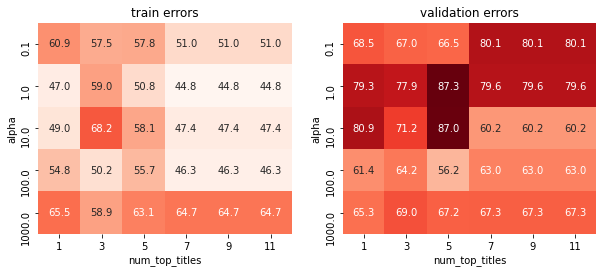

In [334]:
# Trực quan hóa kết quả
train_errs_df = pd.DataFrame(data=np.array(train_errs).reshape(len(alphas), -1),
                             index=alphas, columns=num_top_titles_s)
val_errs_df = pd.DataFrame(data=np.array(val_errs).reshape(len(alphas), -1), 
                           index=alphas, columns=num_top_titles_s)
min_err = min(min(train_errs), min(val_errs))
max_err = max(max(train_errs), max(val_errs))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('train errors'); plt.xlabel('num_top_titles'); plt.ylabel('alpha')
plt.subplot(1, 2, 2)
sns.heatmap(val_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('validation errors'); plt.xlabel('num_top_titles'); plt.ylabel('alpha');

In [335]:

full_pipeline.set_params(pipeline__coladderdropper__num_top_titles = num_top_titles,mlpregressor__alpha = alpha)
full_pipeline.fit(X_df,y_sr)

C:\Users\Admintrastor\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('coladderdropper',
                                  ColAdderDropper(num_top_titles=11)),
                                 ('handle', Handle()), ('onehot', OneHot()),
                                 ('standardscaler', StandardScaler())])),
                ('mlpregressor',
                 MLPRegressor(activation='tanh', alpha=1000,
                              hidden_layer_sizes=50, max_iter=5000,
                              random_state=0, solver='lbfgs'))])

In [355]:
results = full_pipeline.score(X_test, y_test)
results

0.4109690947020306

- Kết quả khá tệ :(